# Romberg 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## introduction

* (composite) trapezoidal rule for quadrature
  $$T(f,h) = \frac{h}{2} \left( f(a) + 2 \sum_{k=1}^{n-1} f(a+kh) + f(b) \right)$$
  where $h= (b-a)/n$ for some integer $n$

* the Romberg method is Richardson extrapolation applied to the trapezoidal rule
* first we need to establish an error formula for the trapezoidal rule
* while in the case of central differences one considers a sequence of increasingly
  coarser grids, for Romberg one consider a sequence of increasingly finer grids
  
## example

In [2]:
f  = lambda x : np.exp(-x)
intf = 1.0 - 1/np.e

# trapezoidal rule
T = lambda f,n,a=0.0,b=1.0 : (b-a)/n*((f(a)+f(b))/2.0 \
    + np.sum(f(np.linspace(a+(b-a)/n,b-(b-a)/n,n-1))))
d = 20   # might have to set lower ...
q = np.zeros(d)
nv = 2**np.arange(d)*4
for i,n in enumerate(nv):
    q[i] = T(f,n)
h = 1.0/nv

def pl1():  # plotting commands
    plt.title('trapezoidal rule')
    plt.gca().invert_xaxis();plt.loglog(h,h*h,label="$h^2$")
    plt.xlabel('h');plt.ylabel('error')
    plt.loglog(h,abs((q - intf)/intf),'.',label="$Q(f)-I(f)$")
    plt.legend();

------------------------------------------

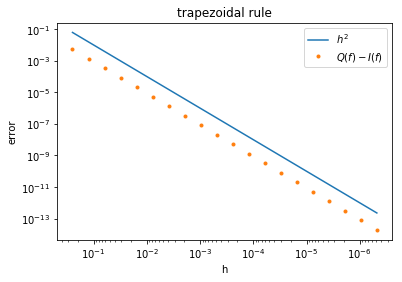

In [3]:
pl1()

## Euler-Maclaurin 

**Theorem**

*Let $f\in C^{2k+1}[a,b]$ and $h=(b-a)/n$. Then* 
  \begin{align*} T(f,h) - \int_a^b f(x)\, dx &= \sum_{k=1}^{m-1} h^{2k} 
    \frac{B_{2k}}{(2k)!}\left(f^{(2k-1)}(b) - f^{(2k-1)}(a)\right) \\ &+
    h^{2m}\frac{B_{2m}}{(2m)!}(b-a)f^{(2m)}(\xi)\end{align*} *where $B_{2k}$ are the Bernoulli numbers.*

* proof by induction and integration by parts
* first few Bernoulli numbers
    $$B_0=1,\; B_2 = 1/6,\; B_4 = -1/30,\; B_6=1/42,\; B_8=-1/30,\ldots$$
* improve quadrature using derivatives
* case of $m=1$ see earlier discussion of trapezoidal rule
* $f$ periodic and analytic: error $o(h^m)$ for all $m$
    * in this case: trapezoidal rule better than Gauss quadrature!

(see Wikipedia)

## Recursive computation of $T(2^{-k}(b-a))$

* compute sequence $T(f,2^{-k}(b-a))$, for $k=0,\ldots,m$ by

$$\begin{aligned}
  T(f,b-a)    &= \frac{(b-a)(f(a)+f(b))}{2} \\
 T\left(f,(b-a)/2 \right) &= \frac{T(f,b-a)}{2}+\frac{(b-a)f\left( a+(b-a)/2\right)}{2}, \\
 T(f,(b-a)/4) &= \frac{T(f,(b-a)/2)}{2} \\ &+ \frac{(b-a)\left(f(a+(b-a)/4)+f(a+3(b-a)/4)\right)}{4} \\
              &   \vdots \\
T(f,(b-a)/2^m) &= \frac{T(f,(b-a)/2^{m-1})}{2} \\
          &+\frac{(b-a)\sum_{i=1}^{2^{m-1}}f\left(a+(2i-1)(b-a)/2^m\right)}{2^m}\end{aligned}$$

## Romberg integration = Richardson extrapolation for trapozoidal rule

* we use 
  $$T(f,h) - I(f) = a_1 h^2 + a_2 h^4 + a_3 h^6 + \cdots$$
  and eliminate $a_1$, then $a_2$, etc
  
* establish lower triangular tableau $R[j,k]$ with
    * leftmost column $$R[j,0] = T(2^{-j}(b-a)) $$
    * elements 
      $$R[j,k] = \frac{4^kR[j,k-1] - R[j-1,k-1]}{4^k-1}$$
    * use the efficient method to update $T(2^{-j}h)$

* error approximation $e_h \approx R[j,j] - R[j+1,j+1]$

## example $f(x) = \exp(-x)$

In [4]:
R  = lambda f,n: (4*T(f,n) - T(f,n/2))/3
qr = np.zeros(d)
for i,n in enumerate(nv[1:]):
    qr[i] = R(f,n)

def pl2():  # plotting commands
    plt.title('trapezoidal rule')
    plt.gca().invert_xaxis();plt.loglog(h,h*h,label="$h^2$")
    plt.xlabel('h');plt.ylabel('error')
    plt.loglog(h,abs((q - intf)/intf),'.',label="trapezoidal")
    plt.loglog(h,abs((qr - intf)/intf),'.',label="extrapolation")
    plt.legend();

/home/hegland/Environment3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


------------------------------------------------------------

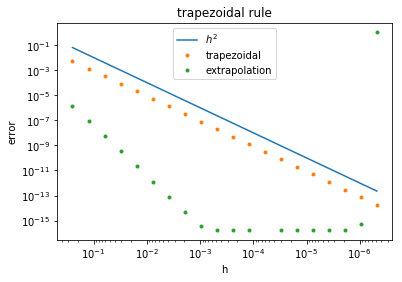

In [5]:
pl2()

## Romberg tableau

* all the $R(i,j)$ required for $R(0,k)$:

$$\begin{array}{cccccc}
R(0,0) & & &  & & \\
R(1,0) & R(1,1) &  &  &  &\\
R(2,0) & R(2,1) & R(2, 2) &  &  &\\
\vdots & \vdots & \vdots & \ddots& &\\
R(n-1,0) & R(n-1, 1) & R(n-1, 2) &  \cdots& R(n-1, n-1) \\
R(n,0) & R(n, 1) & R(n, 2) & \cdots & \cdots &R(n, n) \\
\end{array}$$

* follows from
    $$R[j,k] = \frac{4^kR[j,k-1] - R[j-1,k-1]}{4^k-1}$$

* use $R(j,k)$ for error estimate on diagonal

  $$e_j = R(j,j) - \phi(0) \approx R(j,j) - R(j+1,j+1)$$ 
  
## example

In [6]:
mr = 5; h = 0.1
R = np.zeros((mr,mr))
for n in range(mr):
    R[n,0] = T(f,2**n)
for k in range(1,mr):
    for j in range(k,mr):
        R[j,k] = (4**k*R[j,k-1] - R[j-1,k-1])/(4**k-1)
print(R)
print("exact value: {}".format(intf))

[[0.68393972 0.         0.         0.         0.        ]
 [0.64523519 0.63233368 0.         0.         0.        ]
 [0.63540943 0.63213418 0.63212088 0.         0.        ]
 [0.63294342 0.63212141 0.63212056 0.63212056 0.        ]
 [0.63232631 0.63212061 0.63212056 0.63212056 0.63212056]]
exact value: 0.6321205588285577


## errors

In [7]:
for j in range(mr):
    for k in range(j+1):
        print("{:1.2e}".format(R[j,k]-intf),end='   ')
    print("\n")

5.18e-02   

1.31e-02   2.13e-04   

3.29e-03   1.36e-05   3.16e-07   

8.23e-04   8.56e-07   5.06e-09   1.23e-10   

2.06e-04   5.36e-08   7.96e-11   4.94e-13   1.21e-14   



## error estimate on diagonal

In [8]:
# error approximation for diagonal
print("approx",end='   ')
for k in range(mr-1):
    print("{:1.4e}".format(R[k,k]-R[k+1,k+1]),end='  ')
print("\nexact",end='   ')
for k in range(mr-1):
    print("{:1.4e}".format(R[k,k]-intf),end='  ')

approx   5.1606e-02  2.1280e-04  3.1606e-07  1.2341e-10  
exact   5.1819e-02  2.1312e-04  3.1618e-07  1.2342e-10  

## comments

* practical implementation will require stopping criteria based on error estimate
* the columns converge according to the Euler-Maclaurin formula
* the diagonal may not converge! 
* in contrast to differentiation, rounding errors for integration are usually not a problem